In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import io
from google.colab import files
from numpy import argmax
from numpy import array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
def random_shuffle(filename_features, filename_labels):
  one_hot_encoded_seqs_array = clean_seq(filename_features)
  labels_df = pd.read_csv(filename_labels)
  labels = labels_df['labels']

  frames = [pd.DataFrame(labels), pd.DataFrame(one_hot_encoded_seqs_array)]
  output_data= np.concatenate(frames, axis=1)
  np.random.shuffle(output_data)
  one_hot_encoded_seqs_array_shuffled = output_data[:,1:]
  labels_shuffled = output_data[:,0]
  
  return one_hot_encoded_seqs_array_shuffled, labels_shuffled

def clean_seq(filename):
    seq_df = pd.read_csv(filename, engine='python')
    sequences = seq_df['dna'].str.replace('[^ACGT]','N')
    for i in range(len(sequences)):
        sequences[i] = sequences[i].ljust(1058,'N')
    #print(sequences[0])
    
    sequences_array = np.array(sequences)
    #print(pd.DataFrame(sequences_array))
    seq_list_padded = []
    for i in range(len(sequences_array)):
        list_seq = list(sequences_array[i])
        del list_seq[750:]
        seq_list_padded.append(list_seq)
    print(len(list_seq))
    replace_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'N': 5}
    integer_encoded = []
    for i in range(len(seq_list_padded)):
        C = (pd.Series(seq_list_padded[i])).map(replace_map) #convert the list to a pandas series temporarily before mapping
        integer_encoded.append(list(C))
    data = np.array([1, 2, 3, 4, 5])
    data = data.reshape(-1, 1) 
    integer_encoded = np.array(integer_encoded).astype(int)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(data)
    one_hot_encoded_seqs = []
    for i in range(len(integer_encoded)):
        integer_encoded_tmp = integer_encoded[i].reshape(len(integer_encoded[i]), 1)
        onehot_encoded = np.array(onehot_encoder.transform(integer_encoded_tmp)).flatten()
        one_hot_encoded_seqs.append(onehot_encoded)
    one_hot_encoded_seqs_array = np.array(one_hot_encoded_seqs)
    print(one_hot_encoded_seqs_array.shape)
    
    return one_hot_encoded_seqs_array

def clean_seq_reshape(one_hot_encoded_seqs_array):
    one_hot_encoded_seqs_array = one_hot_encoded_seqs_array.reshape(len(one_hot_encoded_seqs_array), 75, 50)
    one_hot_encoded_seqs_array = np.expand_dims(one_hot_encoded_seqs_array, axis=3)

    return one_hot_encoded_seqs_array

def load_n_encode_labels(labels):
    softmax_layer = len(set(labels))
    le = LabelEncoder()
    le.fit(labels)
    label_seq = le.transform(labels)
    #label_seq = label_seq.reshape(len(label_seq), 1)
    
    return label_seq, le, softmax_layer

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

def generate_class_weights(class_series):
  # Compute class weights with sklearn method
  class_labels = np.unique(class_series)
  class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

  return dict(zip(class_labels, class_weights))

In [ ]:
uploaded = files.upload()

Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_labels.csv to train_labels.csv


In [ ]:
filename_features = 'train_features.csv'
filename_labels = 'train_labels.csv'
one_hot_encoded_seqs_array_shuffled, labels_shuffled = random_shuffle(filename_features, filename_labels)
one_hot_encoded_seqs_array = clean_seq_reshape(one_hot_encoded_seqs_array_shuffled)
label_seq, le, softmax_layer = load_n_encode_labels(labels_shuffled)
input_shape = (75, 50, 1)

750
(12906, 3750)


In [ ]:
# Create a callback that saves the model's weights
#https://jonathan-hui.medium.com/tensorflow-save-restore-model-75a1e6d3b9a6
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(one_hot_encoded_seqs_array, label_seq, test_size=0.2)
class_weights = generate_class_weights(y_train)
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)

(10324, 75, 50, 1)
(10324,)
(2582, 75, 50, 1)
(2582,)


In [ ]:
print(len(y_train))
print(len(set(y_train)))
print(len(class_weights))

10324
1202
1202


In [ ]:
print(len(labels_shuffled))

12906


In [ ]:
X_train = one_hot_encoded_seqs_array
y_train = label_seq
class_weights = generate_class_weights(y_train)
print(X_train.shape)
print(y_train.shape)
print(len(y_train))
print(len(set(y_train)))
print(len(class_weights))

(12906, 65, 50, 1)
(12906,)
12906
1202
1202


In [ ]:
#seq len 750 per species
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(softmax_layer, activation='softmax')
])

optimizer=optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
loss='sparse_categorical_crossentropy'
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=64, epochs=num_epochs, validation_data=(X_validation, y_validation), callbacks=callbacks, verbose=2, class_weight = class_weights)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 49, 16)        80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 24, 16)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 24, 16)        64        
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 24, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 23, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 11, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 11, 32)       

KeyboardInterrupt: ignored

In [ ]:
#seq len 650 per species
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(softmax_layer, activation='softmax')
])

optimizer=optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
loss='sparse_categorical_crossentropy'
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=64, epochs=num_epochs, validation_data=(X_validation, y_validation), callbacks=callbacks, verbose=2, class_weight = class_weights)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 49, 16)        80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 24, 16)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 24, 16)        64        
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 24, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 23, 32)        2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 11, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 11, 32)       

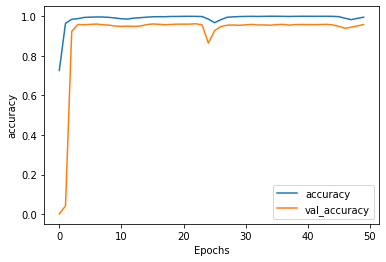

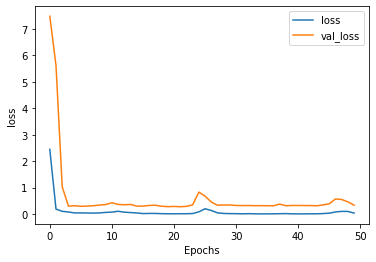

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#loading weights from best model
model.load_weights("mymodel_22")

In [ ]:
#test_data_prediction and submission file creation
filename_features_test = 'test_features.csv'
one_hot_encoded_seqs_array_test = clean_seq(filename_features_test)
one_hot_encoded_seqs_array_test = clean_seq_reshape(one_hot_encoded_seqs_array_test)

750
(8306, 3750)


In [ ]:
#predicting on test data
encoded_predict_labels = np.argmax(model.predict(one_hot_encoded_seqs_array_test), axis=1)
print(encoded_predict_labels)
test_predictions = decode_labels(encoded_predict_labels, le)
print(test_predictions)

[ 659    7  200 ...  658 1059  590]
[ 667.    8.  205. ...  666. 1071.  597.]


In [ ]:
uploaded = files.upload()

Saving outliers_threshold_110_mahalanobis_distance_from_vae_embedding.csv to outliers_threshold_110_mahalanobis_distance_from_vae_embedding.csv


In [ ]:
#Loading outlier predictions based on vae embedding and mahalanobis distance
outlier_df = pd.read_csv('outliers_threshold_110_mahalanobis_distance_from_vae_embedding.csv')
outlier_ids = outlier_df['labels']
test_final_predictions = test_predictions

for i in range(len(outlier_ids)):
  if outlier_ids[i] > 0:
    test_final_predictions[i] = -1 #overwriting outlier label predictions to -1

print(len(test_final_predictions))

8306


In [ ]:
test_final_predictions = test_final_predictions.astype(int)
print(test_final_predictions)
test_ids = get_seq_ids(filename_features_test)
test_ids = test_ids.astype(int)
print(test_ids)

[ 667    8  205 ...  666 1071  597]
[   1    2    3 ... 8304 8305 8306]


In [ ]:
def get_seq_ids(filename):
    df = pd.read_csv(filename)
    ids = df['id']
    
    return np.array(ids)

frames = [pd.DataFrame(test_ids), pd.DataFrame(test_final_predictions)]
output_data= np.concatenate(frames, axis=1)
output_df = pd.DataFrame(output_data)
output_df.to_csv('dna_barcode_seq_submission_cnn_mahalanobis_distance2.csv', index=False,  header=["id","labels"])

In [ ]:
from google.colab import files
files.download("dna_barcode_seq_submission_cnn_mahalanobis_distance2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>